# Multi-Touch Attribution Analysis for Marketing Channel Optimization

## Problem Statement

Understanding and optimizing marketing efficiency is crucial when customers interact with multiple channels before making a purchase. The current **last-click attribution model** fails to capture the full customer journey, leading to potential misallocation of marketing resources and suboptimal campaign performance. The objective is to:

1. Analyze the entire customer journey from initial awareness to final conversion.
2. Assign appropriate credit to each marketing touchpoint based on its influence on the purchase decision.
3. Gain insights into the effectiveness of various channels and campaigns at different stages of the funnel.
4. Optimize the marketing mix and budget allocation for maximum ROI.

## Modeling Approach

The current **last-click attribution model** overemphasizes the final touchpoint in the user journey, failing to capture the influence of earlier interactions. This can lead to a misleading understanding of how different touchpoints contribute to conversions and may result in inefficient marketing strategies.

To address this, we will implement a **Multi-Touch Attribution** model using an **LSTM (Long Short-Term Memory) network** with **Bahdanau attention**. This approach will assign credit to marketing channels based on the entire sequence of user interactions, offering a more comprehensive and accurate view of how each touchpoint contributes to conversions.

Given that user journeys follow a sequential pattern, the model will treat interactions as part of an evolving process rather than isolated events. The attention mechanism allows the model to focus on the most relevant touchpoints in the sequence, making the attribution process more context-aware.

#### Rationale for choosing LSTM
While the task document provided helpful hints about the use of probabilities, patterns, and features, the choice to use **LSTM with Bahdanau attention** was driven by several reasons:

- **Sequential nature of user journeys**: The LSTM model is designed for sequential data, capturing long-term dependencies, which is crucial as user journeys evolve and earlier touchpoints influence later ones.

- **Attention Mechanism**: The attention mechanism in LSTM highlights key touchpoints, enhancing the model’s context-awareness by considering the order, timing, and frequency of interactions.

- **Dynamic modeling vs. Markov Chains**: Unlike Markov Chains, which assume static transition probabilities, LSTM can capture non-linear relationships and dynamic patterns in user journeys, offering more flexibility in understanding complex interactions.

- **Long-term dependencies**: LSTM excels at modeling long-term dependencies, addressing the delayed effects of earlier touchpoints on conversion, a limitation for simpler models like Markov Chains.


In summary, the **LSTM model with Bahdanau attention** is well-suited for capturing the **sequential and evolving nature** of user interactions and attribution, providing a more accurate and comprehensive analysis of marketing touchpoints.

More details on the model and its implementation can be found in the relevant section of this notebook.

## Future Improvements

- **Incorporate Probabilistic Elements**: While LSTM doesn’t model probabilities directly like Markov Chains, we could explore how touchpoints impact conversion likelihood by analyzing sequence outputs and attribution scores.
  
- **Pattern Recognition**: Although LSTM captures sequential dependencies, we can further explore how patterns in touchpoint interactions (such as frequency or order) influence conversions. This can guide future adjustments in the model or marketing strategy.

- **Feature Evaluation**: Investigate the influence of features like timing, frequency, and the order of touchpoints in shaping conversion likelihood. The attention mechanism in LSTM already highlights the relative importance of each touchpoint, but further analysis can help refine the model.

- **Optimize Interaction Window**: Experiment with different interaction windows (sequence length) to assess how varying the length of user journeys affects model performance and conversion predictions.

---

## Data Overview

The dataset contains the following columns:

- **user_id**: A unique identifier for each user.
- **timestamp**: Records the date and time of the user's touchpoint.
- **channel**: Indicates the marketing channel through which the user interacted with the product or brand (e.g., Organic Search, Paid Search, Social Media, Email).
- **converted**: A binary indicator (0 or 1) showing whether the user completed a purchase.
- **utm_medium**: Identifies the marketing medium used (e.g., CPC, organic, email, or social).
- **utm_source**: Specifies the source of the traffic (e.g., Google, Instagram).
- **utm_campaign**: Denotes the specific marketing campaign associated with the user's interaction.
- **device_type**: Categorizes the user's device (e.g., desktop, mobile, tablet).


### Import modules, read data and examine

In [280]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


torch.manual_seed(42)
np.random.seed(42)

In [281]:
data = pd.read_csv("touchpoints_data.csv")

In [282]:
data.head()

,user_id,timestamp,channel,converted,utm_medium,utm_source,utm_campaign,device_type
0,0,2024-11-18 01:09:01.889245,Organic Search,0,organic,bing,seo_campaign,desktop
1,0,2024-11-16 01:09:01.889245,Display,0,banner,ad_network_2,display_ad_campaign,desktop
2,0,2024-11-16 13:09:01.889245,Organic Search,0,organic,yahoo,seo_campaign,tablet
3,0,2024-11-13 20:09:01.889245,Referral,0,referral,partner_site,referral_program,desktop
4,0,2024-11-11 19:09:01.889245,Organic Search,0,organic,bing,seo_campaign,desktop


In [283]:
data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308903 entries, 0 to 308902
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       308903 non-null  int64 
 1   timestamp     308903 non-null  object
 2   channel       308903 non-null  object
 3   converted     308903 non-null  int64 
 4   utm_medium    302628 non-null  object
 5   utm_source    302628 non-null  object
 6   utm_campaign  302628 non-null  object
 7   device_type   308903 non-null  object
dtypes: int64(2), object(6)
memory usage: 18.9+ MB


### Data Cleaning

In [285]:
"""
Remove missing data

"""

data["remove_user"] = np.where(
    data[["utm_medium", "utm_source", "utm_campaign"]].isna().any(axis=1), 1, 0
)

In [286]:
data = data.query("remove_user == 0")
data = data.drop(columns=["remove_user"])

In [287]:
data["time"] = pd.to_datetime(data["timestamp"])

In [288]:
data["day"] = data["time"].dt.day_name()
data["hour"] = data["time"].dt.hour

In [289]:
conditions = [
    (data["hour"] >= 6) & (data["hour"] <= 12),  # morning
    (data["hour"] > 12) & (data["hour"] <= 16),  # afternoon
    (data["hour"] > 16) & (data["hour"] < 24),  # evening
    (data["hour"] < 6),  # night
]

choices = ["morning", "afternoon", "evening", "night"]

In [290]:
data["time_of_day"] = np.select(conditions, choices, default="unknown")
data["date"] = data["time"].dt.date

In [291]:
data.head()

,user_id,timestamp,channel,converted,utm_medium,utm_source,utm_campaign,device_type,time,day,hour,time_of_day,date
0,0,2024-11-18 01:09:01.889245,organic search,0,organic,bing,seo_campaign,desktop,2024-11-18 01:09:01.889245,Monday,1,night,2024-11-18
1,0,2024-11-16 01:09:01.889245,display,0,banner,ad_network_2,display_ad_campaign,desktop,2024-11-16 01:09:01.889245,Saturday,1,night,2024-11-16
2,0,2024-11-16 13:09:01.889245,organic search,0,organic,yahoo,seo_campaign,tablet,2024-11-16 13:09:01.889245,Saturday,13,afternoon,2024-11-16
3,0,2024-11-13 20:09:01.889245,referral,0,referral,partner_site,referral_program,desktop,2024-11-13 20:09:01.889245,Wednesday,20,evening,2024-11-13
4,0,2024-11-11 19:09:01.889245,organic search,0,organic,bing,seo_campaign,desktop,2024-11-11 19:09:01.889245,Monday,19,evening,2024-11-11


## Prepare Data for Input

- **Convert each user’s touchpoints into a sequence of channels**: Organize the user's journey by ordering their interactions with various marketing channels in chronological order.

- **Encode channels using one-hot encoding (OHE)**: Represent each channel as a one-hot encoded vector (or consider embeddings later on for more advanced models like LSTMs).

- **Filter journeys by length**: Retain only the journeys that consist of at least **xx number of touchpoints**. This ensures that you're working with sufficiently rich data, which is especially important for sequential models that rely on context from multiple touchpoints to understand patterns in user behavior.

This preparation step is crucial for sequential modeling, such as LSTM, because these models need to learn the temporal dependencies between touchpoints to make accurate predictions and understand the role of each channel within the user journey.


In [292]:
data = data.sort_values(by=["user_id", "date", "hour"])
cat_vars = ["device_type", "day", "time_of_day"]
cont_vars = []

In [293]:
data.head()

,user_id,timestamp,channel,converted,utm_medium,utm_source,utm_campaign,device_type,time,day,hour,time_of_day,date
4,0,2024-11-11 19:09:01.889245,organic search,0,organic,bing,seo_campaign,desktop,2024-11-11 19:09:01.889245,Monday,19,evening,2024-11-11
12,0,2024-11-11 22:09:01.889245,organic search,0,organic,yahoo,seo_campaign,tablet,2024-11-11 22:09:01.889245,Monday,22,evening,2024-11-11
8,0,2024-11-12 14:09:01.889245,social media,0,paid_social,instagram.com,social_media_campaign,tablet,2024-11-12 14:09:01.889245,Tuesday,14,afternoon,2024-11-12
3,0,2024-11-13 20:09:01.889245,referral,0,referral,partner_site,referral_program,desktop,2024-11-13 20:09:01.889245,Wednesday,20,evening,2024-11-13
9,0,2024-11-13 20:09:01.889245,paid search,0,cpc,google,bing_ads_campaign,desktop,2024-11-13 20:09:01.889245,Wednesday,20,evening,2024-11-13


In [294]:
class UserJourney:

    def __init__(self, data, chosen_level, cat_vars=None, cont_vars=None):
        self.data = data.sort_values(by=["user_id", "date", "hour"])
        self.cat_vars = cat_vars or []
        self.cont_vars = cont_vars or []
        self.chosen_level = chosen_level
        self.channels = data[self.chosen_level].unique()

        # Create "effective" user_id by resetting every user's journey if conversion is reached
        self.data["journey_num"] = self.data.groupby("user_id")["converted"].cumsum()
        # Every user_id_eff is a unique journey
        self.data["user_id_eff"] = (
            self.data["user_id"].astype(str)
            + "_"
            + np.where(
                self.data["converted"] == 1,
                self.data["journey_num"] - 1,
                self.data["journey_num"],
            ).astype(str)
        )
        self.data["unique_journeys"] = self.data.groupby("user_id")[
            "journey_num"
        ].transform("nunique")

        self.data["touchpoint"] = self.data.groupby(["user_id_eff"]).cumcount() + 1
        self.data["num_touchpoints"] = self.data.groupby("user_id_eff")[
            "touchpoint"
        ].transform("max")

        # One-hot-encode every channel touchpoint
        self.data["channel_ohe"] = self.data[self.chosen_level].apply(
            lambda row: [1 if row == channel else 0 for channel in self.channels]
        )

        # Descriptive statistics of user journeys
        self.overall_touchpoint_distribution = (
            self.data.groupby("user_id_eff")["touchpoint"].max().describe()
        )
        self.converted_touchpoint_distribution = self.data.query("converted == 1")[
            "touchpoint"
        ].describe()

        # One-hot-encode other non-channel variables (user features)
        for var in self.cat_vars:
            var_levels = self.data[var].unique()
            self.data[var + "_ohe"] = self.data[var].apply(
                lambda row: [1 if row == level else 0 for level in var_levels]
            )

        for var in self.cont_vars:
            var_levels = self.data[var].unique()
            self.data[var + "_ohe"] = self.data[var].apply(
                lambda row: [1 if row == level else 0 for level in var_levels]
            )

        self.data = self.data.reset_index()
        self.num_converted_journeys = self.data.query("converted == 1")[
            "user_id_eff"
        ].nunique()
        self.num_total_journeys = self.data["user_id_eff"].nunique()

        self.converted_users = self.data.query("converted == 1")["user_id_eff"].unique()
        self.non_converted_users = [
            user
            for user in self.data["user_id_eff"].unique()
            if user not in self.converted_users
        ]

        print("Customer Journey parameters:")
        print(f"\n# of user journeys: {self.num_total_journeys}")
        print(f"# of user journeys successful: {self.num_converted_journeys}")

        print(
            f"\nminimum touchpoints (overall): {self.overall_touchpoint_distribution['min']}"
        )
        print(
            f"median touchpoints (overall): {self.overall_touchpoint_distribution['50%']}"
        )
        print(
            f"maximum touchpoints (overall): {self.overall_touchpoint_distribution['max']}"
        )

        print(
            f"\nminimum touchpoints (successful journey): {self.converted_touchpoint_distribution['min']}"
        )
        print(
            f"median touchpoints (successful journey): {self.converted_touchpoint_distribution['50%']}"
        )
        print(
            f"maximum touchpoints (successful journey): {self.converted_touchpoint_distribution['max']}"
        )

    def filter_by_journey_length(self, min_touchpoints=None):
        if not min_touchpoints:
            min_touchpoints = self.converted_touchpoint_distribution["50%"]
        self.min_len = min_touchpoints
        # Retain only journeys that have atleast min_touchpoints
        self.data = self.data.query("num_touchpoints >= @self.min_len")
        # Retain only last min_touchpoints number of touchpoints in every user journey
        self.data = self.data.groupby("user_id_eff").tail(min_touchpoints)

        self.num_converted_journeys_in_training = self.data["converted"].sum()
        self.id_nonconverted_journeys_in_training = self.data.query("converted == 0")[
            "user_id_eff"
        ].unique()

        print(
            f"Total journeys with at least {int(min_touchpoints)} touchpoints: {self.data['user_id_eff'].nunique()}"
        )
        print(
            f"Converted journeys with at least {int(min_touchpoints)} touchpoints: {self.num_converted_journeys_in_training}"
        )

    def tabular_to_sequential_data(self):

        agg_dict = {"channel_ohe": list, "converted": "max"}
        for var in self.cat_vars + self.cont_vars:
            agg_dict[var + "_ohe"] = list

        self.data = self.data.groupby("user_id_eff", as_index=False).agg(agg_dict)
        rearrange_cols = [col for col in self.data.columns if col != "converted"] + [
            "converted"
        ]
        self.data = self.data[rearrange_cols]

In [295]:
chosen_level = "channel"
preprocessed_df = UserJourney(data, chosen_level=chosen_level, cat_vars=cat_vars)

# Save data copy before further modifications
raw_data = preprocessed_df.data.copy()

# Save mapping of channel and its respective OHE vector (will need later for sequential model)
unique_combos = set(
    (channel, tuple(channel_ohe))
    for channel, channel_ohe in zip(raw_data[chosen_level], raw_data["channel_ohe"])
)
channel_ohe_mapping = {}
for channel, channel_ohe in unique_combos:
    channel_ohe_mapping[channel_ohe] = channel

Customer Journey parameters:

# of user journeys: 24681
# of user journeys successful: 5478

minimum touchpoints (overall): 1.0
median touchpoints (overall): 11.0
maximum touchpoints (overall): 30.0

minimum touchpoints (successful journey): 1.0
median touchpoints (successful journey): 6.0
maximum touchpoints (successful journey): 30.0


##### We observe that journeys that end in a conversion are typically much shorter than journeys that do not convert (6 vs. 11 touchpoints).

- **Quicker Decision-Making**: Converting users make decisions faster with fewer touchpoints.
- **Targeted Interactions**: Conversion journeys are more focused on relevant touchpoints.
- **Abandonment**: Longer journeys may indicate uncertainty or decision fatigue, leading to abandonment.


## 1. Last Touchpoint Attribution (LTA) Model

The **Last Touchpoint Attribution (LTA)** model gives 100% of the credit for a conversion to the last touchpoint a user interacted with before completing the desired action. It ignores all prior touchpoints in the customer journey, such as ads or emails, and focuses solely on the final interaction.

#### Disadvantages:
- **Ignores earlier touchpoints**: Only the last interaction is credited, ignoring earlier influences.
- **Overemphasis on closing channels**: Channels like retargeting ads get all the credit, even if earlier stages played a role.
- **Lack of full journey insights**: Doesn't reflect how multiple touchpoints work together to drive conversion.
- **Inefficient budget allocation**: Focuses on final touchpoints, possibly misdirecting marketing spend.


In [296]:
last_touch_df = raw_data.copy()

cols_of_interest = [
    "user_id",
    "user_id_eff",
    "date",
    "hour",
    "channel",
    "utm_medium",
    "utm_source",
    "utm_campaign",
    "converted",
]
last_touch_df = last_touch_df[cols_of_interest]
last_touch_df.head()

,user_id,user_id_eff,date,hour,channel,utm_medium,utm_source,utm_campaign,converted
0,0,0_0,2024-11-11,19,organic search,organic,bing,seo_campaign,0
1,0,0_0,2024-11-11,22,organic search,organic,yahoo,seo_campaign,0
2,0,0_0,2024-11-12,14,social media,paid_social,instagram.com,social_media_campaign,0
3,0,0_0,2024-11-13,20,referral,referral,partner_site,referral_program,0
4,0,0_0,2024-11-13,20,paid search,cpc,google,bing_ads_campaign,0


In [297]:
attribution_df = last_touch_df.query("converted==1")[["user_id_eff"] + [chosen_level]]
channel_percentage = round(
    attribution_df[chosen_level].value_counts(normalize=True) * 100, 1
)

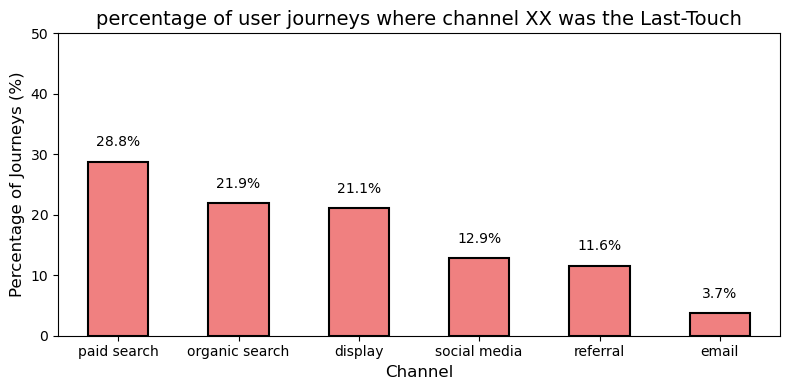

In [298]:
# Plot the bar graph
plt.figure(figsize=(8, 4))
channel_percentage.plot(
    kind="bar", color="lightcoral", edgecolor="black", linewidth=1.5
)


plt.title(
    "percentage of user journeys where channel XX was the Last-Touch", fontsize=14
)
plt.xlabel("Channel", fontsize=12)
plt.ylabel("Percentage of Journeys (%)", fontsize=12)

for i, v in enumerate(channel_percentage):
    plt.text(i, v + 2, f"{v}%", ha="center", va="bottom", fontsize=10)

plt.xticks(rotation=0)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

**Observations**:

- **Paid Search** (28.8%) receives the highest percentage of conversions, indicating that users often convert after interacting with paid ads, suggesting the channel's effectiveness in driving immediate conversions.
- **Organic Search** (21.9%) also shows a significant share, highlighting the importance of search engine visibility in the user journey, especially for users who perform direct searches.
- **Display Ads** (21.1%) represent a strong presence, indicating that display campaigns are successful in capturing the final touchpoint before conversion, likely due to retargeting efforts.
- **Social Media** (12.9%) is a notable contributor, showing that social interactions can drive conversions, though it plays a lesser role than paid and organic search.
- **Referral** (11.6%) suggests that third-party sites and recommendations play a relevant, but smaller role in final conversions, showing some influence on user decisions.
- **Email** (3.7%) has the lowest attribution, despite being a common tool for engagement, potentially indicating a smaller, but important role in closing conversions compared to other channels.


## **2. Sequence-based LSTM Model**


The goal of this sequence-based LSTM model is to predict the conversion of users across different marketing touchpoints, such as `channel`, `utm_medium`, `utm_source`, etc. Although the model is trained to predict conversion, the primary focus is on understanding the importance of each touchpoint in the user journey. To achieve this, the Bahdanau attention mechanism is implemented, allowing for an interpretative view of which touchpoints contribute most to the conversion decision.

**Footnote:** We have not performed hyperparameter tuning for this model. Despite that, we achieve an accuracy of ~84% on the validation data. The primary emphasis was on the attention mechanism rather than maximizing prediction accuracy.

### Handling variance in journey lengths

A challenge observed in this problem is the significant variance in the number of touchpoints in user journeys. Some users convert after a single touchpoint, while others may take up to 30 touchpoints before converting. This variation introduces complexity in the sequence modeling process. 

The median journey length for converted journeys is 6 touchpoints. To ensure consistency and mitigate the influence of overly short or excessively long sequences, the data is filtered to include only those journeys that contain at least 6 touchpoints. This filtering step is designed to remove outliers that may skew the learning process.

### Review of the filtering approach:
The decision to filter journeys with fewer than 6 touchpoints is based on the observation that the majority of conversions happen within a moderate number of touchpoints (median = 6). This approach ensures that the model focuses on the more common, representative sequences. However, it is important to assess if filtering out these shorter journeys might exclude meaningful information about quick conversions. It could be worth testing if a smaller threshold or different filtering criterion impacts model performance.

### Sequence length standardization for LSTM

LSTM models typically require sequences of a fixed length for processing. To accommodate this, sequences with more than 6 touchpoints are truncated to the last 6 touchpoints. This step ensures that all sequences, regardless of their original length, are processed consistently. 

### Review of the sequence truncation decision:
The decision to limit sequences to the last 6 touchpoints is a trade-off between maintaining the most recent information while discarding earlier context that might be less relevant. Since the model aims to predict conversion based on recent touchpoints, this approach makes sense for capturing the most pertinent user behaviors. However, it may be useful to experiment with longer sequence lengths or consider an attention mechanism that allows the model to weigh earlier touchpoints more effectively. The truncation approach is a simplification, and evaluating its impact on prediction accuracy and interpretability is recommended.

### Context vectors

In addition to sequential touchpoints, context vectors derived from user characteristics are included in the model. These context vectors represent high-level information about the user, such as:

- Device type (e.g., mobile, desktop)
- Day of the week
- Time of day

These context vectors are used alongside the sequential touchpoints to enhance the model's ability to account for external factors that could influence conversion behavior. The inclusion of context vectors ensures that the model not only learns from the touchpoint sequence but also adapts to user-specific patterns and temporal factors.

### Attention mechanism

To extract the importance of each touchpoint in the journey, the Bahdanau attention mechanism is implemented. This mechanism allows the model to learn a set of attention weights, reflecting how much each touchpoint contributes to the final prediction. By analyzing these weights, it becomes possible to interpret which touchpoints were most influential in driving conversion, providing valuable insights into the user journey.


In [299]:
min_touchpoints = int(preprocessed_df.converted_touchpoint_distribution["50%"])
preprocessed_df.filter_by_journey_length(
    min_touchpoints=min_touchpoints
)  # every journey should have at least xx # of touchpoints. And LSTM works on last xx

Total journeys with at least 6 touchpoints: 17641
Converted journeys with at least 6 touchpoints: 2950


In [300]:
preprocessed_df.tabular_to_sequential_data()

In [301]:
preprocessed_df.data.head(3)

,user_id_eff,channel_ohe,device_type_ohe,day_ohe,time_of_day_ohe,converted
0,0_0,"[[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0...","[[1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0],...","[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0,...",0
1,10000_0,"[[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0...","[[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [...","[[0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1,...",1
2,10000_1,"[[0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0], [1, 0...","[[0, 1, 0], [1, 0, 0], [0, 0, 1], [1, 0, 0], [...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...",0


### Train LSTM 

In [302]:
class TrainingData(Dataset):

    def __init__(
        self,
        preprocessed_data,
        channels=preprocessed_df.channels,
        min_len=preprocessed_df.min_len,
    ):
        self.df = preprocessed_data
        self.input_size = len(channels)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_data = self.df.iloc[idx]
        original_index = self.df.index[idx]  # Getting the original index

        channel_ohe = user_data["channel_ohe"]
        converted = user_data["converted"]

        X = torch.tensor(channel_ohe, dtype=torch.float32)
        y = torch.tensor(converted, dtype=torch.float32)

        return X, y, original_index

In [303]:
# """
# Class Imbalance: undersample majority class

# """

# training_df = preprocessed_df.data
# minority_class = training_df[training_df["converted"] == 1]
# majority_class = training_df[training_df["converted"] == 0]

# num_minority = minority_class.shape[0]
# num_majority = majority_class.shape[0]

# print(f"Imbalanced ratio: {int(num_minority/num_minority)}:{int(np.ceil(num_majority/num_minority))}")

# desired_multiple = 2 # Must be an integer
# undersample_majority = majority_class.sample(int(desired_multiple*num_minority))
# training_df = pd.concat([minority_class, undersample_majority], axis = 0).sample(frac=1)

# if int(training_df[training_df["converted"] == 0].shape[0]/training_df[training_df["converted"] == 1].shape[0]) == desired_multiple:
#     print(f"Corrected ratio: 1:{desired_multiple}")

In [304]:
training_df = preprocessed_df.data

In [305]:
train_data, val_data = train_test_split(
    training_df, test_size=0.3, shuffle=True
)  # 70% for training, 30% for testing and validation

In [306]:
train_dataset = TrainingData(preprocessed_data=train_data)
val_dataset = TrainingData(preprocessed_data=val_data)

batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

In [307]:
class TouchpointAttention(nn.Module):

    def __init__(self, hidden_size, user_feature_size):
        super().__init__()
        self.W = nn.Linear(
            user_feature_size + hidden_size, hidden_size
        )  # assuming ANN also has hidden_size neurons
        self.v = nn.Linear(
            hidden_size, 1
        )  # weights going into output (which is the context vector)

        # Initialize weights for better gradient flow
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.zeros_(self.W.bias)
        nn.init.xavier_uniform_(self.v.weight)
        nn.init.zeros_(self.v.bias)

    def forward(self, lstm_out, **user_feature_input):
        # lstm_out: (batch_size, seq_len, hidden_size)
        # each user_feature_input: (batch_size, seq_len, input_size) input_size is feature-specific

        # concatenate user features with hidden_state of each touchpoint
        input_for_attention = torch.cat(
            [lstm_out] + [user_feature_input[key] for key in user_feature_input], dim=2
        )

        # feed input into ANN hidden layer
        alignment_scores = F.leaky_relu(
            self.W(input_for_attention)
        )  # Leaky ReLU activation
        # alignment_scores = torch.tanh(self.W(input_for_attention)) # batch_size, seq_len, hidden_size (remember hidden_size of ANN)

        # feed output of previous step into output and eliminate last dim
        attention_scores = self.v(alignment_scores).squeeze(-1)  # batch_size, seq_len

        # softmax to normalize across time-steps
        channel_credit_scores = F.softmax(
            attention_scores, dim=1
        )  # batch_size, seq_len

        context_vector = torch.sum(
            channel_credit_scores.unsqueeze(2) * lstm_out, dim=1
        )  # batch_size, hidden_size

        return context_vector, channel_credit_scores

In [308]:
class mta_LSTM_WithAttention(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, user_feature_size=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.user_feature_size = user_feature_size or 0

        self.attention_mechanism = TouchpointAttention(
            hidden_size=self.hidden_size, user_feature_size=self.user_feature_size
        )

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )

        # Initialize LSTM weights
        nn.init.orthogonal_(self.lstm.weight_hh_l0)
        nn.init.xavier_uniform_(self.lstm.weight_ih_l0)

        self.fc = nn.Linear(
            hidden_size * 2, output_size
        )  # prediction based on journey + user_features
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, **user_feature_input):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden_state = h_n[-1]  # shape (batch_size, hidden_size)

        context_vector, channel_credit_scores = self.attention_mechanism(
            lstm_out, **user_feature_input
        )

        out = self.fc(torch.cat((last_hidden_state, context_vector), dim=1))
        out = self.sigmoid(out)
        return out, channel_credit_scores

In [309]:
input_size = len(preprocessed_df.channels)  # length of each channel OHE vector
hidden_size = 8
output_size = 1

if cat_vars + cont_vars:
    user_feature_size = 0
    for user_feature in cat_vars + cont_vars:
        user_feature_size += data[user_feature].nunique()

model = mta_LSTM_WithAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    user_feature_size=user_feature_size,
)

In [310]:
# Standard loss function
criterion = nn.BCELoss()

# Special loss function to address class imbalance
class_0_weight = 1.0  # for the majority class
class_1_weight = 5.0  # for the minority class (5 times more important)
weights = torch.tensor([class_0_weight, class_1_weight]).float() 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])  

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [270]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    samples_channel_credit = []
    samples_index = []
    tp, fn = 0, 0

    for inputs, targets, idx in train_loader:
        user_feature_input = {}
        index = idx.detach().numpy()

        for var in cat_vars + cont_vars:
            feature_array = np.stack(
                preprocessed_df.data.iloc[index][var + "_ohe"].to_numpy()
            )
            feature_tensor = torch.tensor(feature_array, dtype=torch.float32)
            user_feature_input[var] = (
                feature_tensor  # Shape (batch_size, seq_len, input_size)
            )

        outputs, channel_credits = model(inputs, **user_feature_input)
        samples_channel_credit.append(channel_credits.detach().numpy())
        samples_index.append(index)
        

        loss = criterion(outputs, targets.unsqueeze(1))  # shape (batch_size, 1)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        running_train_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    tp += ((predicted == 1) & (targets == 1)).sum().item()
    fn += ((predicted == 0) & (targets == 1)).sum().item()
    train_recall = tp/(tp+fn) * 100

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    tp, fn = 0, 0

    with torch.no_grad():
        for inputs, targets, idx in val_loader:
            user_feature_input = {}
            index = [index.item() for index in idx]

            for var in cat_vars + cont_vars:
                feature_array = np.stack(
                    preprocessed_df.data.iloc[index][var + "_ohe"].to_numpy()
                )
                feature_tensor = torch.tensor(feature_array, dtype=torch.float32)
                user_feature_input[var] = (
                    feature_tensor  # Shape (batch_size, seq_len, input_size)
                )

            outputs, channel_credits = model(inputs, **user_feature_input)

            loss = criterion(outputs, targets.unsqueeze(1))
            running_val_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
            
            tp += ((predicted == 1) & (targets == 1)).sum().item()
            fn += ((predicted == 0) & (targets == 1)).sum().item()

        val_recall = tp/(tp + fn) * 100
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Recall: {train_recall:.2f}% "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Recall: {val_recall:.2f}%" 
       
    )

Epoch [1/50], Train Loss: 1.1773, Train Accuracy: 81.75%, Train Recall: 0.00% Val Loss: 1.1420, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [2/50], Train Loss: 1.1623, Train Accuracy: 83.04%, Train Recall: 0.00% Val Loss: 1.1402, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [3/50], Train Loss: 1.1607, Train Accuracy: 83.04%, Train Recall: 0.00% Val Loss: 1.1382, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [4/50], Train Loss: 1.1582, Train Accuracy: 83.04%, Train Recall: 0.00% Val Loss: 1.1356, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [5/50], Train Loss: 1.1549, Train Accuracy: 83.04%, Train Recall: 0.00% Val Loss: 1.1324, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [6/50], Train Loss: 1.1501, Train Accuracy: 83.04%, Train Recall: 0.00% Val Loss: 1.1278, Val Accuracy: 83.83%, Val Recall: 0.00%
Epoch [7/50], Train Loss: 1.1444, Train Accuracy: 82.76%, Train Recall: 0.00% Val Loss: 1.1228, Val Accuracy: 83.20%, Val Recall: 3.27%
Epoch [8/50], Train Loss: 1.1392, Train Accuracy

## Translate attention scores of sequential touchpoints into attribution percentage ("credit score")

The Bahdanau attention mechanism assigns weights to each touchpoint in the sequence, reflecting its contribution to the conversion. These weights can be normalized and converted into an attribution percentage, or "credit score," for each touchpoint.



In [271]:
"""
Prepare DataFrame of credit scores (each row is a user journey and columns are touchpoints) 

"""

channel_credits_for_samples = [
    credit_score for batch in samples_channel_credit for credit_score in batch
]
ordering_of_samples = [index for batch in samples_index for index in batch]

credits_df = pd.DataFrame(channel_credits_for_samples, index=ordering_of_samples)
print(
    "The Dataframe below shows, for every converted user journey, credit scores assigned to the last 6 touchpoints."
)

converted_indices = train_data.query("converted == 1").index
credits_df = credits_df[credits_df.index.isin(converted_indices)]
credits_df.sample(frac=1).head()

The Dataframe below shows, for every converted user journey, credit scores assigned to the last 6 touchpoints.


,0,1,2,3,4,5
7773,0.194427,0.107651,0.052317,0.173675,0.451943,0.019986
2014,0.000199,0.000459,0.000358,0.000011,0.522494,0.476480
2494,0.214261,0.103014,0.415291,0.064430,0.075175,0.127830
15003,0.013972,0.007593,0.006401,0.000091,0.049864,0.922079
13525,0.285357,0.002830,0.193107,0.260278,0.113385,0.145043


In [272]:
"""
Validate that all the indices of credits_df are in the original dataset
"""

if [idx for idx in credits_df.index if idx not in preprocessed_df.data.index] == []:
    print("Validation successful!")

Validation successful!


In [273]:
"""
Convert colum
"""

temp_df = credits_df.merge(
    train_data["channel_ohe"], how="inner", left_index=True, right_index=True
)
temp_df["channel_name"] = temp_df["channel_ohe"].apply(
    lambda x: [channel_ohe_mapping.get(tuple(ohe), "Unknown") for ohe in x]
)

In [274]:
temp_df.head(3)

,0,1,2,3,4,5,channel_ohe,channel_name
2955,0.312534,0.185018,0.041221,0.020517,0.141424,0.299287,"[[1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [1, 0...","[organic search, referral, organic search, ref..."
321,0.135609,0.004282,0.006888,0.001555,0.106848,0.744818,"[[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0...","[paid search, display, referral, paid search, ..."
13246,0.010526,0.004682,0.001323,0.003199,0.655236,0.325034,"[[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0...","[social media, organic search, referral, refer..."


In [275]:
final_credits_for_converted_users = {}
for idx, row in credits_df.iterrows():
    final_credits_for_converted_users[idx] = [
        {v: round(k, 4)}
        for k, v in zip(credits_df.loc[idx], temp_df.loc[idx]["channel_name"])
    ]

In [276]:
final_credits_for_converted_users = pd.DataFrame(final_credits_for_converted_users).T
final_credits_for_converted_users.columns = [
    "touchpoint_" + str(i + 1) for i in range(min_touchpoints)
]
final_credits_for_converted_users.head()

,touchpoint_1,touchpoint_2,touchpoint_3,touchpoint_4,touchpoint_5,touchpoint_6
2955,{'organic search': 0.3125},{'referral': 0.185},{'organic search': 0.0412},{'referral': 0.0205},{'paid search': 0.1414},{'social media': 0.2993}
321,{'paid search': 0.1356},{'display': 0.0043},{'referral': 0.0069},{'paid search': 0.0016},{'referral': 0.1068},{'paid search': 0.7448}
13246,{'social media': 0.0105},{'organic search': 0.0047},{'referral': 0.0013},{'referral': 0.0032},{'organic search': 0.6552},{'display': 0.325}
3538,{'social media': 0.103},{'display': 0.0661},{'referral': 0.1048},{'display': 0.042},{'paid search': 0.5073},{'paid search': 0.1768}
3691,{'organic search': 0.1088},{'display': 0.0232},{'organic search': 0.0052},{'organic search': 0.0023},{'display': 0.34},{'social media': 0.5205}


### Compare last touchpoint attribution from LSTM model with LTA model 
(observations shown below the charts)

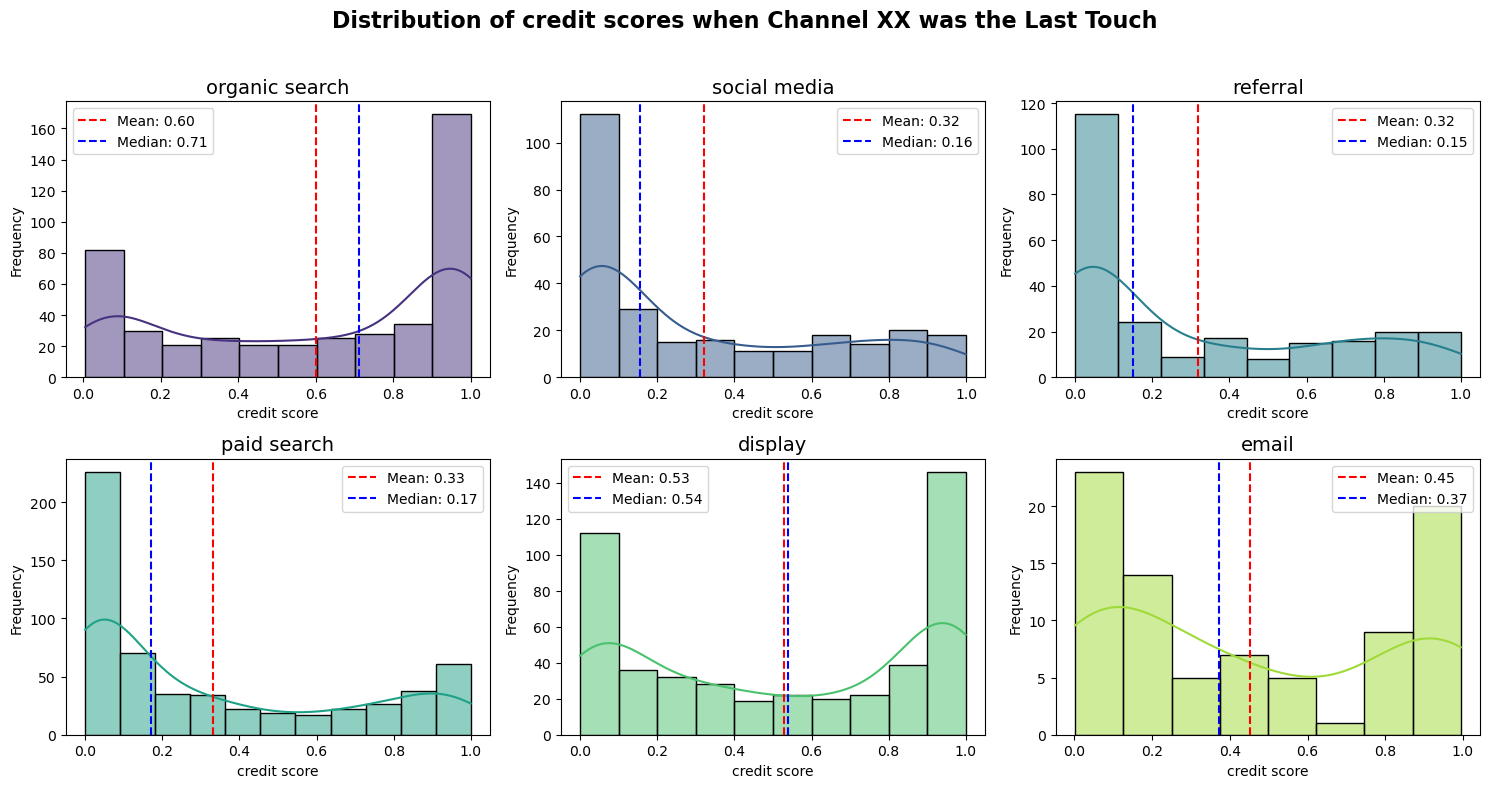

In [277]:
last_touch_dicts = final_credits_for_converted_users.iloc[:, -1]

last_touch_df = pd.DataFrame(
    [(key, value) for d in last_touch_dicts for key, value in d.items()],
    columns=["touchpoint", "credit"],
)

channels = preprocessed_df.channels
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
palette = sns.color_palette(
    "viridis", n_colors=len(channels)
)  # Generate a list of colors

for i, channel in enumerate(channels):
    channel_data = last_touch_df[last_touch_df["touchpoint"] == channel]

    sns.histplot(channel_data["credit"], kde=True, ax=ax[i], color=palette[i])

    mean_credit = channel_data["credit"].mean()
    median_credit = channel_data["credit"].median()

    ax[i].axvline(
        mean_credit, color="red", linestyle="--", label=f"Mean: {mean_credit:.2f}"
    )
    ax[i].axvline(
        median_credit,
        color="blue",
        linestyle="--",
        label=f"Median: {median_credit:.2f}",
    )

    ax[i].set_title(f"{channel}", fontsize=14)
    ax[i].set_xlabel("credit score")
    ax[i].set_ylabel("Frequency")
    ax[i].legend()


plt.suptitle(
    "Distribution of credit scores when Channel XX was the Last Touch",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top to fit the suptitleplt.legend()

plt.show()

#### Observations 

The comparison between the LSTM-based attribution model and the Last Touch Attribution (LTA) model reveals several key insights:

- **The Last Touchpoint is not the dominant channel**: Unlike the Last Touchpoint Attribution (LTA) model, which assigns 100% of attribution to the last touchpoint, the LSTM model distributes attribution more evenly across multiple touchpoints. Typically, the attribution to the Last Touchpoint ranges between 17% and 71%, indicating that the LTA model tends to overestimate the influence of the last touchpoint.

- Last touch influence is **channel-dependent**: The influence of the last touchpoint is not universal across all channels. It varies depending on the type of channel, highlighting the context-specific nature of attribution. _Organic search_ seems to have very high attribution when it is the last touch-point (typically 71%), whereas _social media_, on the other hand has very low attribution when it is the last touchpoint (typically 16%). 

- **User features** impact channel influence: The variation in credit scores across channels suggests that user characteristics (such as device type, time of day, etc.) play a significant role in shaping the attribution for each channel.

These insights are further illustrated by the following charts, which show how attribution for the same channel can vary based on the position of the touchpoint in the user's journey.

### Channel influence depends on position in user journey
(observations shown below the charts)

In [278]:
channel_avg_credits = pd.DataFrame(columns=final_credits_for_converted_users.columns)
for channel in channels:

    touch_positions = final_credits_for_converted_users.columns
    avg_in_this_position = {}
    for position in touch_positions:
        placeholder = final_credits_for_converted_users[
            final_credits_for_converted_users[position].apply(lambda x: channel in x)
        ][position]
        placeholder = placeholder.apply(lambda x: x.get(channel))

        avg_in_this_position[position] = placeholder.mean()
    channel_avg_credits = pd.concat(
        [channel_avg_credits, pd.DataFrame(avg_in_this_position, index=[channel])]
    )

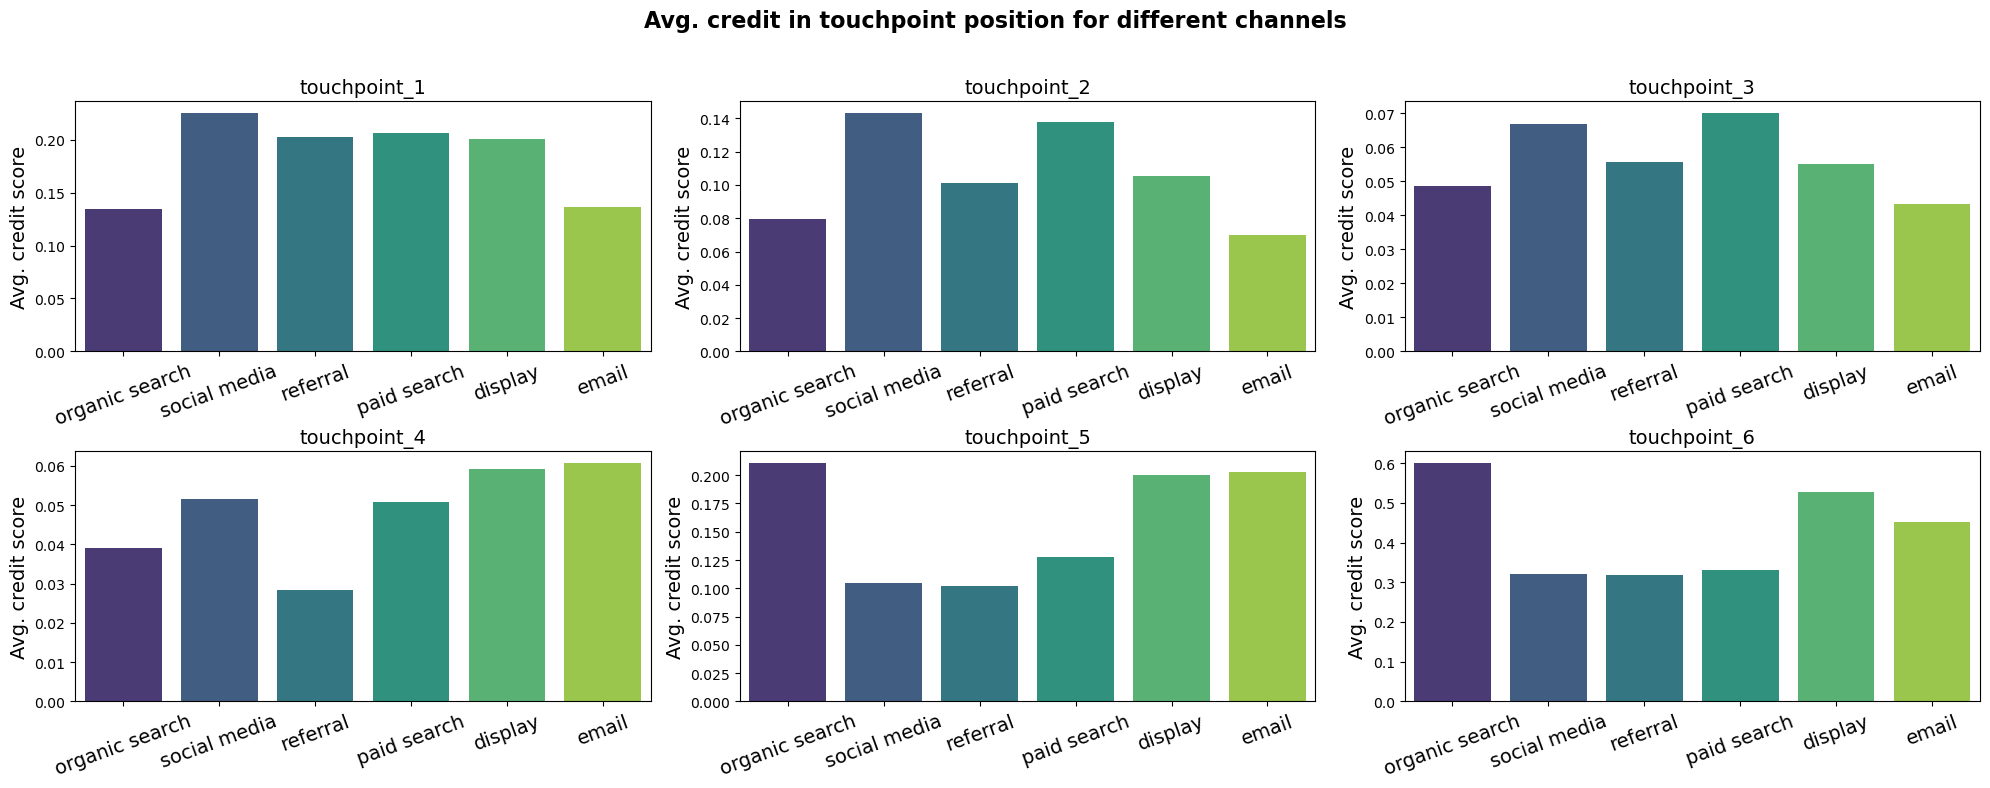

In [279]:
nrows = 2
ncols = int(len(channel_avg_credits.columns) / nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
ax = ax.flatten()
touchpoints = channel_avg_credits.columns
palette = sns.color_palette("viridis", n_colors=len(channels))

# Loop through each touchpoint and plot the credit scores for all channels
for i, touchpoint in enumerate(touchpoints):
    # Extract credit scores for all channels at this touchpoint
    touchpoint_data = channel_avg_credits[touchpoint]

    # Create the bar plot for this touchpoint
    sns.barplot(x=channels, y=touchpoint_data.values, ax=ax[i], palette=palette)

    ax[i].set_title(f"{touchpoint}", fontsize=14)
    ax[i].set_ylabel("Avg. credit score", fontsize=14)
    ax[i].tick_params(axis="x", rotation=20, labelsize=14)


plt.suptitle(
    "Avg. credit in touchpoint position for different channels",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Observations^

The charts clearly show the relationship between channel effectiveness and touchpoint position, highlighting that some channels are more effective at different stages of the funnel:

- **Social Media** and **Paid Search** perform best in the **upper funnel**, where they likely drive awareness and initial interest.
- **Referral** channels show an interesting pattern in that they seem to have high attribution in upper funnel, substantially low in the middle and high again in the lower funnel. This behaviour could be occurring because of two potential reasons:
    - Referrals really are only most effective in the lower funnel and the high "upper funnel" attribution we see is only because we truncated some long user journeys at last-six touchpoints.
    - Or it could mean that Referrals really are good at creating awareness, for users who might be aware already, the referrals also good at converting them because they find the referral source trustworthy, have high intent, or the Call-to-Action is more convincing in the lower funnel.
- **Organic Search** stands out as the **clear winner** deeper in the funnel, likely capturing users with strong purchase intent.
- **Display** performs well at **touchpoint_6**, indicating that it may be used for **retargeting** ads to bring users back before conversion.

**^ Important Note**: Since around 50% of user journeys had more than 6 touchpoints, only the last 6 touchpoints were considered. Therefore, "touchpoint 1" does not necessarily correspond to the first touchpoint in a user’s journey. However, it does indicate a position further up the funnel, and the model has successfully identified the relative importance of touchpoints closer to conversion.


## 3. Conclusions and recommendations

#### 3a. Assessing which method provides the most reliable attribution results?

To assess which method provides the most reliable attribution results, I’d focus on the following:

1. **Distribution of attribution**:
   - In my analysis, I found that the **LSTM model** distributes attribution more evenly across multiple touchpoints, unlike the **Last Touchpoint Attribution (LTA)** model, which assigns 100% of the attribution to the last touchpoint. On average, the LSTM model gave the last touchpoint between **30-60%** of the attribution, indicating that it’s not overestimating the importance of the last touch as the LTA model tends to do. The LSTM model’s ability to consider all touchpoints makes it a more balanced and reliable reflection of how user journeys unfold.

2. **Context-specific channel influence**:
   - The LSTM model revealed that the effectiveness of channels varies depending on the position of the touchpoint in the user journey. For example, **Social Media** and **Paid Search** perform better at the top of the funnel, while **Organic Search** tends to have more influence deeper in the funnel. This context-dependent attribution is something the LTA model misses, which gives the LSTM model an edge in reliability since it accounts for the fact that different channels serve different purposes at different stages of the journey.

3. **User features impacting attribution**:
   - Another key insight from my analysis was that **user features** (like device type or time of day) significantly affect the attribution for each channel. The LSTM model takes these features into account, giving it the ability to offer **more personalized insights** than the LTA model. This makes the LSTM approach more robust and reflective of real-world scenarios.

4. **Comparison with traditional models**:
   - I’d also recommend comparing the results from the LSTM model with other traditional models (like first-touch or last-touch attribution) through A/B testing or simulations. This would help me further validate if the LSTM model truly delivers more reliable results in terms of predicting real-world business outcomes like conversions or revenue.

---

#### 3b. Based on the attribution results of the LSTM model, the following questions can be answered.

##### i. Which channels perform best in converting users at the end of the funnel?

Based on my model, **Organic Search** stands out as the channel with the strongest performance deeper in the funnel, suggesting that users engaging with Organic Search are likely to have strong purchase intent. The model consistently shows that **Organic Search** has a high credit score at later touchpoints, which indicates its importance in driving conversions.

- **Recommendation**: I’d recommend that the marketing team invest more resources into **SEO** and **content optimization** to capitalize on the conversion potential of Organic Search. This could include improving rankings for high-intent keywords and ensuring the content is tailored to users already looking to purchase.

##### ii. Which channels help in raising awareness at the beginning of the funnel?

**Social Media** and **Paid Search** perform well in the **upper funnel**, where they likely help generate awareness and spark initial interest in the brand. These channels tend to have a higher impact earlier in the user journey, where users are just becoming aware of the brand or product.

- **Recommendation**: I’d suggest allocating more budget to **Social Media campaigns** (like sponsored posts or influencer partnerships) and **Paid Search** to maximize visibility and attract new users to the brand. These channels are best positioned to introduce the brand and generate early-stage interest in potential customers.


---

##### Additional insights and recommendations

Based on the attribution analysis, I've identified key channels that play significant roles in nurturing users towards conversion and retargeting those who may have dropped off earlier in the journey:

1. **Referral Channels**:
   - **Insight**: **Referral** channels are particularly effective at the **upper** and **lower** parts of the funnel, indicating that users who are either just getting introduced to the brand or have dropped off can be guided towards conversion through these channels.
   - **Recommendation**: Strengthen **Referral programs** or partnerships to nurture users in the **upper funnel** (new users) and **lower funnel** (users nearing conversion). Focusing on **building trust** and leveraging word-of-mouth can help move users further down the funnel.

2. **Display Ads for Retargeting**:
   - **Insight**: **Display Ads** are most effective at the **last touchpoint** (credit score ~.5 at Touchpoint 6), highlighting their role in **retargeting** users who have previously interacted with the brand but have not yet converted.
   - **Recommendation**: Optimize **retargeting campaigns** with Display Ads. Target users who dropped off earlier in the funnel to re-engage them with personalized ads, maximizing conversion potential just before the final decision is made.

---

#### 3c. Steps to take the model to Production for daily insights

1. **Model Deployment**: Package the model using Docker or similar tools to ensure a consistent environment across all platforms, then deploy it on a cloud service (e.g., AWS, GCP, Azure) to ensure scalability and reliability for daily processing.

2. **Data Pipeline Automation**: Automate the process of gathering fresh user data for model inference, ensuring it’s up-to-date, and set up batch or real-time processing based on the use case to provide daily updates or real-time insights.

3. **Model Inference**: Set up a scheduled job (e.g., using cron jobs) to run the model’s inference process on fresh data daily, and expose the model's predictions via an API for easy querying by other systems.


Additionally, continuous monitoring is crucial to track model performance, detect any drift, and ensure accuracy. Automated alerts should notify stakeholders of significant changes.

